# Generative Adversarial Networks

Gregor Cerar  
2023-10-10

Generative Adversarial Networks (GANs) represent an innovative class of
unsupervised neural networks that have revolutionized the field of
artificial intelligence. Eager to learn how they work, I’ve implemented
foundational “vanilla” GAN and its more complex counterpart, the Deep
Convolutional GAN (DCGAN), from scratch. I’ve put them on a test run on
MNIST Digits and Fashion toy datasets.

# Introduction

Generative Adversarial Networks (GANs) are an innovative class of
unsupervised neural networks that have revolutionized the field of
artificial intelligence. They were first introduced in [Generative
Adversarial Networks](https://arxiv.org/abs/1406.2661) (Goodfellow et
al. 2014) and consist of two separate neural networks: the **generator**
(creates data) and the **discriminator** (evaluates data authenticity).
The generator aims to fool the discriminator by producing realistic
data, while the discriminator tries to differentiate real from fake.
Over iterations, the generator’s data becomes more convincing.

As an analogy, consider two kids, one drawing counterfeit money
(“Generator”) and another assessing its realism (“Discriminator”). Over
time, the counterfeit drawings become increasingly convincing.

# Vanilla GAN

The most fundamental variant of GAN is the “vanilla” GAN, where
“vanilla” signifies the model in its original and most straightforward
form rather than a flavor. To better understand its mechanism, I’ve
illustrated its structure on
<a href="#fig-architecture" class="quarto-xref">Figure 1</a>.

<figure id="fig-architecture">
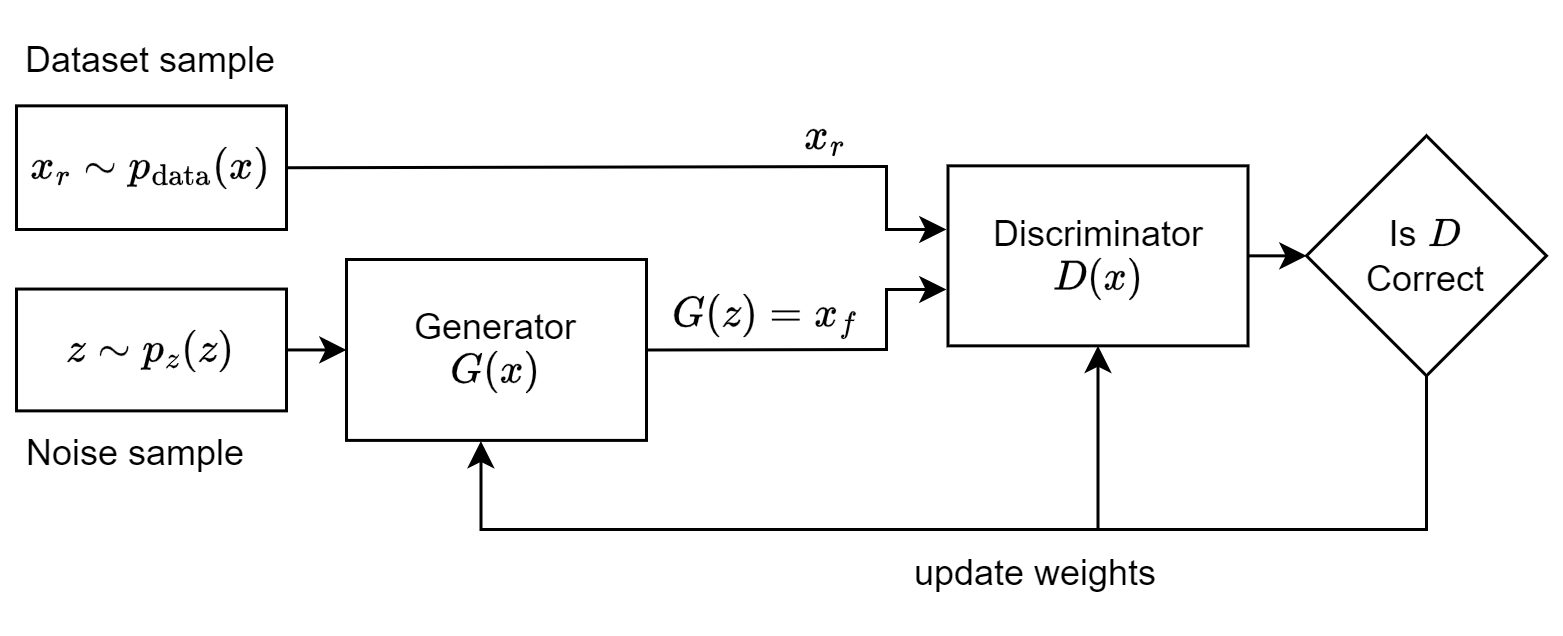
<figcaption>Figure 1: GAN architecture</figcaption>
</figure>

-   **Generator** $G(z; w_g)$ takes random noise $z$ as input and
    produces fabricated data $x_f$.
    -   $z$ represents the input vector, a noise vector from the
        Gaussian distribution.
    -   $w_g$ denotes generator neural network weights.
    -   $x_f$ is a fabricated data sample meant for the discriminator.
-   **Discriminator** $D(x; w_d)$ differentiates between real and
    generated data.
    -   $x$ represents input vectors, which come from either a real
        dataset ($x_r \sim p_\textrm{data}(x)$) or from the set of
        fabricated samples ($x_f = G(z \sim p_z(z); w_g)$).
    -   $w_d$ denodes discriminator neural network weights.

## Objective Function

The interaction between the Generator and the Discriminator can be
quantified by their objective or loss functions:

-   **Discriminator’s Objective:** For real data $x$, $D$ wants $D(x)$
    near $1$. For generated data $G(z)$, it targets $D(G(z))$ close to
    $0$. Its objective is:

$$
\mathcal{L}(D) = \log(D(x)) + \log(1 - D(G(z))).
$$

-   **Generator’s Objective:** $G$ aims for $D(G(z))$ to approach $1$,
    given by:

$$
\mathcal{L}(G) = \log⁡(1 − D(G(z)))
$$

Both $G$ and $D$ continuously improve to outperform each other in this
game.

### Minimax Game in GANs

Vanilla GANs are structured around the minimax game from game theory:

$$
\min_{G}\max_{D} \mathcal{L}(D, G) = \log(D(x)) + \log(1 - D(G(z)))
$$

In essence:

-   **Discriminator:** Maximizes its capacity to differentiate real data
    from generated.
-   **Generator:** Minimizes the discriminator’s success rate by
    producing superior forgeries.

The iterative competition refines both, targeting a proficient Generator
and a perceptive Discriminator.

## Prepare Components

In the upcoming sections, we’ll do the following steps to prepare the
development environment:

-   Import necessary libraries, primarily PyTorch and Matplotlib.
-   Define constants, including project path and seed, for consistency.
-   Determine the computational device (e.g., GPU).
-   Provide a weight initialization helper function.

In [1]:
from collections.abc import Callable, Sequence
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

%config InlineBackend.figure_formats = {'retina', 'png'}

import torch
from torch import Tensor, nn, optim
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchinfo import summary
from torchvision import transforms as T
from torchvision.utils import make_grid
from tqdm import tqdm

SEED = 42

PROJECT_PATH = Path(".").resolve()
FIGURE_PATH = PROJECT_PATH / "figures"
DATASET_PATH = Path.home() / "datasets"

In [3]:
AMP_ENABLED = False

device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

    if torch.cuda.is_bf16_supported():
        AMP_ENABLED = True

In [4]:
def weights_init(net: nn.Module) -> None:
    for m in net.modules():
        if isinstance(m, nn.Conv2d | nn.ConvTranspose2d):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

        elif isinstance(m, nn.BatchNorm1d | nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

### Generator

The Generator in GANs acts as an artist, crafting data.

-   **Input:** Takes random noise, typically from a standard normal
    distribution.
-   **Architecture:** Uses dense layers, progressively increasing data
    dimensions.
-   **Output:** Reshapes data to desired format (e.g., image). Often
    uses ‘tanh’ for activation.
-   **Objective:** Generate data indistinguishable from real by the
    Discriminator.

In [6]:
class Generator(nn.Module):
    def __init__(self, out_dim: Sequence[int], nz: int = 100, ngf: int = 256, alpha: float = 0.2):
        """
        :param out_dim: output image dimension / shape
        :param nz: size of the latent z vector $z$
        :param ngf: size of feature maps (units in the hidden layers) in the generator
        :param alpha: negative slope of leaky ReLU activation
        """
        super().__init__()
        self.out_dim = out_dim
        self.model = nn.Sequential(
            nn.Linear(nz, ngf),
            nn.LeakyReLU(alpha, inplace=True),
            nn.Linear(ngf, 2 * ngf),
            nn.LeakyReLU(alpha, inplace=True),
            nn.Linear(2 * ngf, 4 * ngf),
            nn.LeakyReLU(alpha, inplace=True),
            nn.Linear(4 * ngf, int(np.prod(self.out_dim))),
            nn.Tanh(),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.model(x)
        x = torch.reshape(x, (x.size(0), *self.out_dim))
        return x


summary(Generator(out_dim=(1, 28, 28)), input_size=[128, 100])

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [128, 1, 28, 28]          --
├─Sequential: 1-1                        [128, 784]                --
│    └─Linear: 2-1                       [128, 256]                25,856
│    └─LeakyReLU: 2-2                    [128, 256]                --
│    └─Linear: 2-3                       [128, 512]                131,584
│    └─LeakyReLU: 2-4                    [128, 512]                --
│    └─Linear: 2-5                       [128, 1024]               525,312
│    └─LeakyReLU: 2-6                    [128, 1024]               --
│    └─Linear: 2-7                       [128, 784]                803,600
│    └─Tanh: 2-8                         [128, 784]                --
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 190.25
Input size (MB): 0.05
Forward/backward pass size (MB): 2.64
Params size (MB): 5.95
Estim

### Discriminator

The Discriminator is GAN’s evaluator, distinguishing real from fake
data.

-   **Input:** Takes either real data samples or those from the
    Generator.
-   **Architecture:** Employs dense layers for binary classification of
    the input.
-   **Output:** Uses a sigmoid activation, yielding a score between 0-1,
    reflecting the data’s authenticity.
-   **Objective:** Recognize real data and identify fake data from the
    Generator.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_dim: Sequence[int], ndf: int = 128, alpha: float = 0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(input_dim)), 4 * ndf),
            nn.LeakyReLU(alpha, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(4 * ndf, 2 * ndf),
            nn.LeakyReLU(alpha, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(2 * ndf, ndf),
            nn.LeakyReLU(alpha, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(ndf, 1),
            nn.Sigmoid(),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = torch.reshape(x, (x.size(0), -1))
        return self.model(x)


summary(Discriminator(input_dim=(1, 28, 28)), input_size=[128, 1, 28, 28])

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [128, 1]                  --
├─Sequential: 1-1                        [128, 1]                  --
│    └─Linear: 2-1                       [128, 512]                401,920
│    └─LeakyReLU: 2-2                    [128, 512]                --
│    └─Dropout: 2-3                      [128, 512]                --
│    └─Linear: 2-4                       [128, 256]                131,328
│    └─LeakyReLU: 2-5                    [128, 256]                --
│    └─Dropout: 2-6                      [128, 256]                --
│    └─Linear: 2-7                       [128, 128]                32,896
│    └─LeakyReLU: 2-8                    [128, 128]                --
│    └─Dropout: 2-9                      [128, 128]                --
│    └─Linear: 2-10                      [128, 1]                  129
│    └─Sigmoid: 2-11                     [128, 1]                  --


## Traning Loop

The training process is iterative:

-   **Update Discriminator:** With the Generator static, improve the
    Discriminator’s detection of real vs. fake.
-   **Update Generator:** With a static Discriminator, enhance the
    Generator’s ability to deceive.

Training continues until the Generator produces almost authentic data.
Equilibrium is reached when the Discriminator sees every input as
equally likely real or fake, assigning a probability of $\frac{1}{2}$.

> **Note**
>
> Using `.eval()` and `.train()` modes initially seemed promising for
> faster training. However, they affected layers like `BatchNorm2d` and
> `Dropout`, making the GAN diverge. Also, switching between eval and
> train modes is not free of charge.

In [8]:
def train_step(
    generator: nn.Module,
    discriminator: nn.Module,
    optim_G: optim.Optimizer,
    optim_D: optim.Optimizer,
    criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    real_data: torch.Tensor,
    noise_dim: int,
    device: torch.device,
) -> tuple[float, float]:
    batch_size = real_data.size(0)

    real_data = real_data.to(device)

    # Labels for real and fake data
    real_labels = torch.ones(batch_size, 1, device=device)
    fake_labels = torch.zeros(batch_size, 1, device=device)

    ### Train Discriminator

    # Real data
    output_real = discriminator(real_data)
    loss_D_real = criterion(output_real, real_labels)

    # Fake data
    noise = torch.randn(batch_size, noise_dim, dtype=torch.float, device=device)
    fake_data = generator(noise)
    output_fake = discriminator(fake_data.detach())
    loss_D_fake = criterion(output_fake, fake_labels)

    # Backprop and optimize for discriminator
    loss_D = (loss_D_real + loss_D_fake) / 2.0
    discriminator.zero_grad()
    loss_D.backward()
    optim_D.step()

    ### Train Generator

    # Recompute fake data’s discriminator scores
    output_fake = discriminator(fake_data)
    loss_G = criterion(output_fake, real_labels)

    # Backprop and optimize for generator
    generator.zero_grad()
    loss_G.backward()
    optim_G.step()

    return loss_G.item(), loss_D.item()

## Evaluation

Before evaluation, we configured the learning rate (LR), optimizer’s
$\beta$ parameters, batch size, and data loader settings for all
experiments. We used the MNIST digits and MNIST fashion datasets for
assessment.

In [9]:
OPTIMIZER_LR = 0.0002
L2_NORM = 1e-5
OPTIMIZER_BETAS = (0.5, 0.999)
N_EPOCHS = 100
BATCH_SIZE = 128

In [10]:
g = torch.Generator()
g.manual_seed(SEED)

loader_kwargs = {
    "num_workers": 8,
    "pin_memory": True,
    "shuffle": True,
    "batch_size": BATCH_SIZE,
    "prefetch_factor": 16,
    "persistent_workers": False,
    "worker_init_fn": seed_worker,
    "generator": g,
}

### MNIST Digits Dataset

The MNIST (Modified National Institute of Standards and Technology)
dataset is a well-known collection of handwritten digits, extensively
used in the fields of machine learning and computer vision for training
and testing purposes. Its simplicity and size make it a popular choice
for introductory courses and experiments in image recognition.

In total, the dataset contains 70,000 grayscale images of handwritten
digits (from 0 to 9). Each image is 28x28 pixels.

In [11]:
def get_minst_dataset(transform=None) -> Dataset:
    from torchvision.datasets import MNIST

    root = str(DATASET_PATH)
    trainset = MNIST(root=root, train=True, download=True, transform=transform)
    testset = MNIST(root=root, train=False, download=True, transform=transform)
    # Combine train and test dataset for more samples.
    dataset = ConcatDataset([trainset, testset])
    return dataset

In [13]:
IMG_DIM = (1, 28, 28)
NOISE_DIM = 100

In [14]:
transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(0.5, 0.5),
    ]
)

data = get_minst_dataset(transform=transform)
dataloader = DataLoader(data, **loader_kwargs)

# set seed for random generators
set_random_seed()

# benchmark_noise is used for the animation to show how output evolve on the same vector
benchmark_noise = torch.randn(16 * 16, NOISE_DIM, device=device)

generator = Generator(out_dim=IMG_DIM, nz=NOISE_DIM).to(device)
generator.apply(weights_init)

discriminator = Discriminator(input_dim=IMG_DIM).to(device)
discriminator.apply(weights_init)

optimizer_G = optim.AdamW(
    generator.parameters(),
    lr=OPTIMIZER_LR,
    betas=OPTIMIZER_BETAS,
    weight_decay=L2_NORM,
)

optimizer_D = optim.AdamW(
    discriminator.parameters(),
    lr=OPTIMIZER_LR,
    betas=OPTIMIZER_BETAS,
    weight_decay=L2_NORM,
)

criterion = nn.BCELoss().to(device)

In [15]:
animation: list[Tensor] = []

g_losses: list[float] = []
d_losses: list[float] = []

for _ in tqdm(range(N_EPOCHS), unit="epochs"):
    generator.train()
    discriminator.train()

    for samples_real, _ in dataloader:
        g_loss, d_loss = train_step(
            generator, discriminator, optimizer_G, optimizer_D, criterion, samples_real, NOISE_DIM, device
        )

        g_losses.append(g_loss)
        d_losses.append(d_loss)

    generator.eval()
    with torch.inference_mode():
        images = generator(benchmark_noise)
        images = images.detach().cpu()

        images = make_grid(images, nrow=16, normalize=True)
        animation.append(images)

100%|██████████| 100/100 [07:44<00:00,  4.64s/epochs]

[./figures/gan-mnist.mp4](./figures/gan-mnist.mp4)

### MNIST Fashion Dataset

The Fashion MNIST dataset is a collection of grayscale images of 10
different categories of clothing items, designed as a more challenging
alternative to the classic MNIST dataset of handwritten digits. Each
image in the dataset is 28x28 pixels. The 10 categories include items
like t-shirts/tops, trousers, pullovers, dresses, coats, sandals, and
more. With 70,000 images, Fashion MNIST is commonly used for
benchmarking machine learning algorithms, especially in image
classification tasks.

In [18]:
IMG_DIM = (1, 28, 28)
NOISE_DIM = 100

In [19]:
def get_mnist_fashion_dataset(transform=None):
    from torchvision.datasets import FashionMNIST

    root = str(DATASET_PATH)
    trainset = FashionMNIST(root=root, train=True, download=True, transform=transform)
    testset = FashionMNIST(root=root, train=False, download=True, transform=transform)
    # Combine train and test dataset for more samples.
    dataset = ConcatDataset([trainset, testset])
    return dataset

In [20]:
transform = T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)])

data = get_mnist_fashion_dataset(transform=transform)
dataloader = DataLoader(data, **loader_kwargs)

# set seed for random generators
set_random_seed()

# benchmark_noise is used for the animation to show how output evolve on same vector
benchmark_noise = torch.randn(16 * 16, NOISE_DIM, device=device)

generator = Generator(out_dim=IMG_DIM, nz=NOISE_DIM).to(device)
generator.apply(weights_init)

discriminator = Discriminator(input_dim=IMG_DIM).to(device)
discriminator.apply(weights_init)

optimizer_G = optim.AdamW(
    generator.parameters(),
    lr=OPTIMIZER_LR,
    betas=OPTIMIZER_BETAS,
    weight_decay=L2_NORM,
)

optimizer_D = optim.AdamW(
    discriminator.parameters(),
    lr=OPTIMIZER_LR,
    betas=OPTIMIZER_BETAS,
    weight_decay=L2_NORM,
)

criterion = nn.BCELoss().to(device)

In [21]:
animation = []

g_losses, d_losses = [], []
for _ in tqdm(range(N_EPOCHS), unit="epochs"):
    generator.train()
    discriminator.train()

    for samples_real, _ in dataloader:
        g_loss, d_loss = train_step(
            generator, discriminator, optimizer_G, optimizer_D, criterion, samples_real, NOISE_DIM, device
        )

        g_losses.append(g_loss)
        d_losses.append(d_loss)

    generator.eval()
    with torch.inference_mode():
        images = generator(benchmark_noise)
        images = images.detach().cpu()

        images = make_grid(images, nrow=16, normalize=True)

        animation.append(images)

100%|██████████| 100/100 [07:46<00:00,  4.67s/epochs]

[./figures/gan-fashion.mp4](./figures/gan-fashion.mp4)

# DCGAN

DCGAN, short for Deep Convolutional Generative Adversarial Network,
differs from vanilla GAN by using convolutional layers. This design
makes DCGAN better for image data. With specific architectural
guidelines, DCGAN trains more consistently and generates clearer images
than vanilla GANs across various hyperparameters.

## Setting Up DCGANs

### Generator

In [24]:
class Generator(nn.Module):
    def __init__(self, nz: int = 100, ngf: int = 32, nc: int = 1):
        """
        :param nz: size of the latent z vector
        :param ngf: size of feature maps in generator
        :param nc: number of channels in the training images.
        """
        super().__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(nz, 4 * ngf, 4, 1, 0, bias=False),
            nn.BatchNorm2d(4 * ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(4 * ngf, 2 * ngf, 3, 2, 1, bias=False),
            nn.BatchNorm2d(2 * ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(2 * ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = torch.reshape(x, (x.size(0), -1, 1, 1))
        return self.layers(x)


summary(Generator(), input_size=(128, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [128, 1, 28, 28]          --
├─Sequential: 1-1                        [128, 1, 28, 28]          --
│    └─ConvTranspose2d: 2-1              [128, 128, 4, 4]          204,800
│    └─BatchNorm2d: 2-2                  [128, 128, 4, 4]          256
│    └─ReLU: 2-3                         [128, 128, 4, 4]          --
│    └─ConvTranspose2d: 2-4              [128, 64, 7, 7]           73,728
│    └─BatchNorm2d: 2-5                  [128, 64, 7, 7]           128
│    └─ReLU: 2-6                         [128, 64, 7, 7]           --
│    └─ConvTranspose2d: 2-7              [128, 32, 14, 14]         32,768
│    └─BatchNorm2d: 2-8                  [128, 32, 14, 14]         64
│    └─ReLU: 2-9                         [128, 32, 14, 14]         --
│    └─ConvTranspose2d: 2-10             [128, 1, 28, 28]          512
│    └─Tanh: 2-11                        [128, 1, 28, 28]          --

### Discriminator

In [25]:
class Discriminator(nn.Module):
    def __init__(self, ndf: int = 32, nc: int = 1, alpha: float = 0.2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(alpha, inplace=True),
            nn.Conv2d(ndf, 2 * ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(2 * ndf),
            nn.LeakyReLU(alpha, inplace=True),
            nn.Conv2d(2 * ndf, 4 * ndf, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(alpha, inplace=True),
            nn.Conv2d(4 * ndf, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.layers(x)
        x = torch.reshape(x, (x.size(0), -1))
        return x


summary(Discriminator(), input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [128, 1]                  --
├─Sequential: 1-1                        [128, 1, 1, 1]            --
│    └─Conv2d: 2-1                       [128, 32, 14, 14]         512
│    └─BatchNorm2d: 2-2                  [128, 32, 14, 14]         64
│    └─LeakyReLU: 2-3                    [128, 32, 14, 14]         --
│    └─Conv2d: 2-4                       [128, 64, 7, 7]           32,768
│    └─BatchNorm2d: 2-5                  [128, 64, 7, 7]           128
│    └─LeakyReLU: 2-6                    [128, 64, 7, 7]           --
│    └─Conv2d: 2-7                       [128, 128, 4, 4]          73,728
│    └─BatchNorm2d: 2-8                  [128, 128, 4, 4]          256
│    └─LeakyReLU: 2-9                    [128, 128, 4, 4]          --
│    └─Conv2d: 2-10                      [128, 1, 1, 1]            2,048
│    └─Sigmoid: 2-11                     [128, 1, 1, 1]            --
T

## Evaluation

### MNIST Digits Dataset

In [26]:
IMG_DIM = (1, 28, 28)
NOISE_DIM = 128

transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(0.5, 0.5),
    ]
)

data = get_minst_dataset(transform)
dataloader = DataLoader(data, **loader_kwargs)

# set seed for random generators
set_random_seed()

# benchmark_noise is used for the animation to show how output evolve on same vector
benchmark_noise = torch.randn(16 * 16, NOISE_DIM, device=device)

generator = Generator(nz=NOISE_DIM, ngf=32, nc=IMG_DIM[0]).to(device)
generator.apply(weights_init)

discriminator = Discriminator(ndf=32, nc=IMG_DIM[0]).to(device)
discriminator.apply(weights_init)

optimizer_G = optim.AdamW(
    generator.parameters(),
    lr=OPTIMIZER_LR,
    betas=OPTIMIZER_BETAS,
    weight_decay=L2_NORM,
)

optimizer_D = optim.AdamW(
    discriminator.parameters(),
    lr=OPTIMIZER_LR,
    betas=OPTIMIZER_BETAS,
    weight_decay=L2_NORM,
)

criterion = nn.BCELoss().to(device)

In [27]:
animation = []

g_losses, d_losses = [], []
for _ in tqdm(range(N_EPOCHS), unit="epochs"):
    generator.train()
    discriminator.train()

    for samples_real, _ in dataloader:
        g_loss, d_loss = train_step(
            generator, discriminator, optimizer_G, optimizer_D, criterion, samples_real, NOISE_DIM, device
        )

        g_losses.append(g_loss)
        d_losses.append(d_loss)

    generator.eval()
    with torch.inference_mode():
        images = generator(benchmark_noise)
        images = images.detach().cpu()

        images = make_grid(images, nrow=16, normalize=True)

        animation.append(images)

100%|██████████| 100/100 [05:22<00:00,  3.22s/epochs]

[./figures/dcgan-mnist.mp4](./figures/dcgan-mnist.mp4)

### MNIST Fashion Dataset

In [30]:
IMG_DIM = (1, 28, 28)
NOISE_DIM = 128

transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(0.5, 0.5),
    ]
)

data = get_mnist_fashion_dataset(transform)
dataloader = DataLoader(data, **loader_kwargs)

# set seed for random generators
set_random_seed()

# benchmark_noise is used for the animation to show how output evolve on same vector
benchmark_noise = torch.randn(16 * 16, NOISE_DIM, device=device)

generator = Generator(nz=NOISE_DIM, ngf=32, nc=IMG_DIM[0]).to(device)
generator.apply(weights_init)

discriminator = Discriminator(ndf=32, nc=IMG_DIM[0]).to(device)
discriminator.apply(weights_init)

optimizer_G = optim.AdamW(
    generator.parameters(),
    lr=OPTIMIZER_LR,
    betas=OPTIMIZER_BETAS,
    weight_decay=L2_NORM,
)

optimizer_D = optim.AdamW(discriminator.parameters(), lr=OPTIMIZER_LR, betas=OPTIMIZER_BETAS, weight_decay=L2_NORM)

criterion = nn.BCELoss().to(device)  # F.binary_cross_entropy_with_logits #nn.BCELoss().to(device)

In [31]:
animation = []

g_losses, d_losses = [], []
for _ in tqdm(range(N_EPOCHS), unit="epochs"):
    generator.train()
    discriminator.train()

    for samples_real, _ in dataloader:
        g_loss, d_loss = train_step(
            generator, discriminator, optimizer_G, optimizer_D, criterion, samples_real, NOISE_DIM, device
        )

        g_losses.append(g_loss)
        d_losses.append(d_loss)

    generator.eval()
    with torch.inference_mode():
        images = generator(benchmark_noise)
        images = images.detach().cpu()

        images = make_grid(images, nrow=16, normalize=True)

        animation.append(images)

100%|██████████| 100/100 [05:24<00:00,  3.24s/epochs]

[./figures/dcgan-mnist-fashion.mp4](./figures/dcgan-mnist-fashion.mp4)

# Conclusion

Generative Adversarial Networks (GANs) represent an innovative class of
unsupervised neural networks that have significantly impacted the field
of artificial intelligence (AI). They consist of two components: a
Generator that improves its output and a Discriminator that enhances its
evaluative skills. In a competitive yet symbiotic relationship, these
two networks converge towards a dynamic equilibrium. This interaction
exemplifies the strength of GANs and the adaptability of adversarial
learning in AI, blending creative generation with critical assessment.

In this post, I explore the original GAN, often referred to as the
“vanilla” GAN. My aim was to understand the basic mechanics of how GANs
operate. Meanwhile, others have advanced this technology, applying it to
a range of innovative and fascinating new areas.

-   [18 Impressive Applications of Generative Adversarial Networks
    (GANs)](https://machinelearningmastery.com/impressive-applications-of-generative-adversarial-networks/)

Goodfellow, Ian J., Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David
Warde-Farley, Sherjil Ozair, Aaron Courville, and Yoshua Bengio. 2014.
“Generative Adversarial Networks.” <https://arxiv.org/abs/1406.2661>.